In [4]:
!pip install osmnx
!pip install geopandas
!pip install pandas
!pip install matplotlib

In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load from GeoPackage
gdf = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin.gpkg", layer="country")
counties = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin.gpkg", layer="counties")

# Load CSV of counties
counties_csv = pd.read_csv("/kaggle/input/counties-data/kenya_counties.csv")

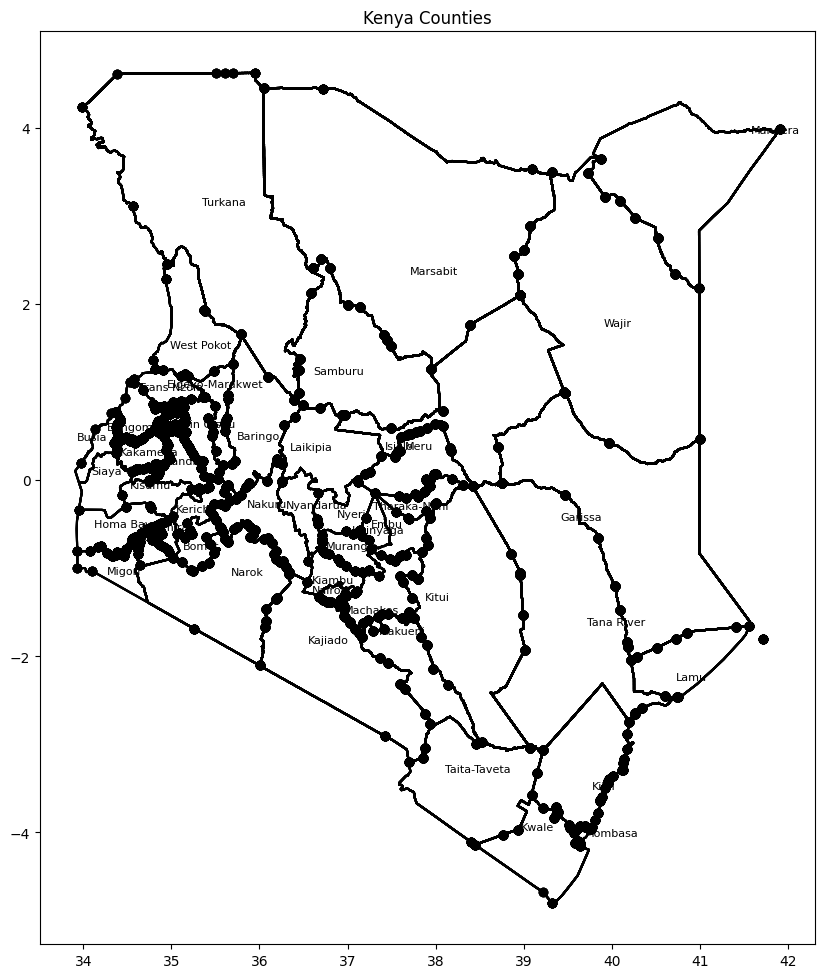

In [10]:
kenya_poly = gdf.iloc[0].geometry
counties = gpd.clip(counties, kenya_poly)
# Plot counties
fig, ax = plt.subplots(figsize=(10, 12))
counties.boundary.plot(ax=ax, color="black")

# Overlay centroid labels from CSV
for _, row in counties_csv.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["County"], fontsize=8, ha="center")

ax.set_title("Kenya Counties")
plt.show()